In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colors

from IPython.display import clear_output

from neutronMS import MS_sim, GEN_constQgeom, E2k, k2E
from Sears_analytical_f import delta_slab, cylinder

In [2]:
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
mu_s = 1
mu_abs = 0
S_files = ('./data_Sq/Sqw_vanadium/S_mesh.npy', './data_Sq/Sqw_vanadium/Q_vec.npy', './data_Sq/Sqw_vanadium/omega_vec.npy')

<Figure size 800x500 with 0 Axes>

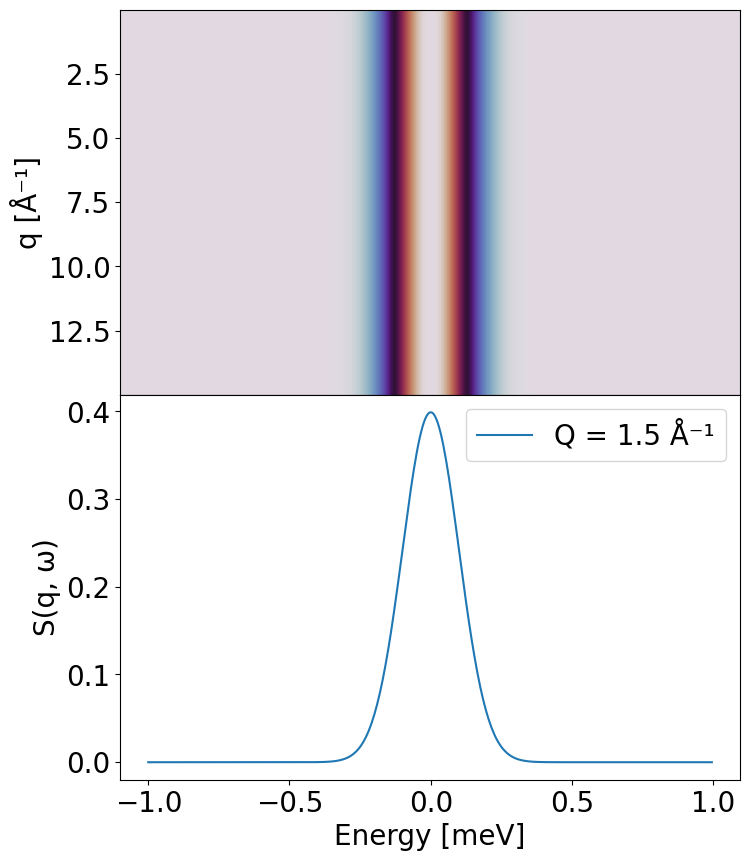

In [4]:
sim = MS_sim(('cuboid', 1, 1, 1), (mu_s,mu_abs), S_files, 1, 1, 1,)

plt.figure(figsize=(8, 5))
fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].imshow(sim.Sij, cmap='twilight', aspect='auto', extent=sim.S_imshow_extent)
ax[0].set_ylabel('q [Å⁻¹]')
ax[0].set_xticks([])
plt.subplots_adjust(hspace=0)
q = 1.5
ax[1].plot(sim.omegaj, sim.Sij[int(q/sim.Qi[1]), :], label=f'Q = {q} Å⁻¹')
ax[1].set_xlabel('Energy [meV]')
ax[1].set_ylabel('S(q, ω)')
ax[1].legend()


# Infinite slab

## $\Sigma d$ dependence

In [5]:
#####################################################
k = 6
theta=np.deg2rad(60)
d_vec = .001, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1
N = 100000
B = 3
#####################################################

ki = kf = k
data = pd.DataFrame({'d':d_vec, 'ki':ki, 'kf':kf, 'theta':np.rad2deg(theta), 'Is':np.nan, 'Im':np.nan, 'delta':np.nan})
print('ki =', ki, 'A-1')
print('kf =', kf, 'A-1')
print('theta =', round(np.rad2deg(theta)), 'deg')


ki = 6 A-1
kf = 6 A-1
theta = 60 deg


In [6]:
# run the simulation
for i in data.index:
    geom = ('cuboid', data.d[i], 1000, 1000)
    sim = MS_sim(geom, (mu_s,mu_abs), S_files, ki, kf, theta,)
    out = sim.run(N=N, B=B)
    data.loc[i,'Is'] = sim.Is
    data.loc[i,'Im'] = sim.Im
    data.loc[i,'delta'] = sim.Im/sim.Is

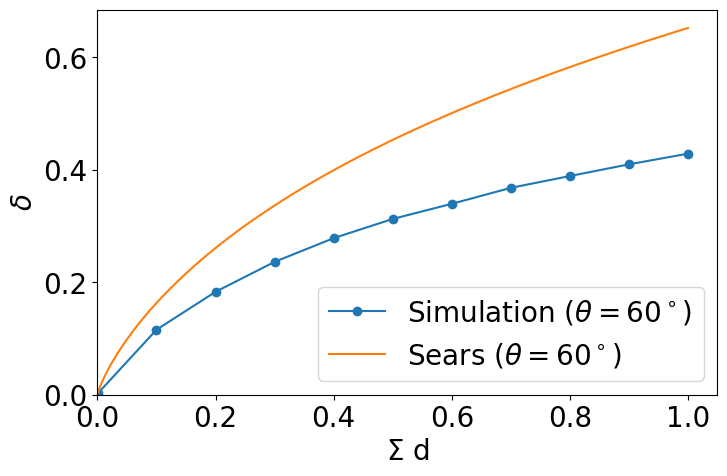

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(data.d, data.delta, 'o-', label=r'Simulation ($\theta = {}^\circ$)'.format(round(np.rad2deg(theta))))
X = np.linspace(data.d.min(), data.d.max(), 1000)
plt.plot(X, delta_slab(X, theta), label=r'Sears ($\theta = {}^\circ$)'.format(round(np.rad2deg(theta))))


plt.xlim(0)
plt.ylim(0)

plt.xlabel(r'$\Sigma$ d')
plt.ylabel(r'$\delta$')
plt.legend()

It is an underestimation of the Sears predictions! We have to integrate the spectrums as we are not using a delta!!! Here follows an example...

### Example of elastic peak integration

In [8]:
domega = 0.05
Nomega = 21
omega_vec = np.linspace(-domega*(Nomega//2), domega*(Nomega//2), Nomega)
kfs = E2k(k2E(ki)+omega_vec)

Im = np.zeros(Nomega)
Is = np.zeros(Nomega)

j=0
for i in range(Nomega):
    geom = ('cuboid', .4, 1000, 1000)
    sim = MS_sim(geom, (mu_s,mu_abs), S_files, ki, kfs[i], theta,)
    out = sim.run(N=100000, B=3)
    Im[i] = sim.Im
    Is[i] = sim.Is

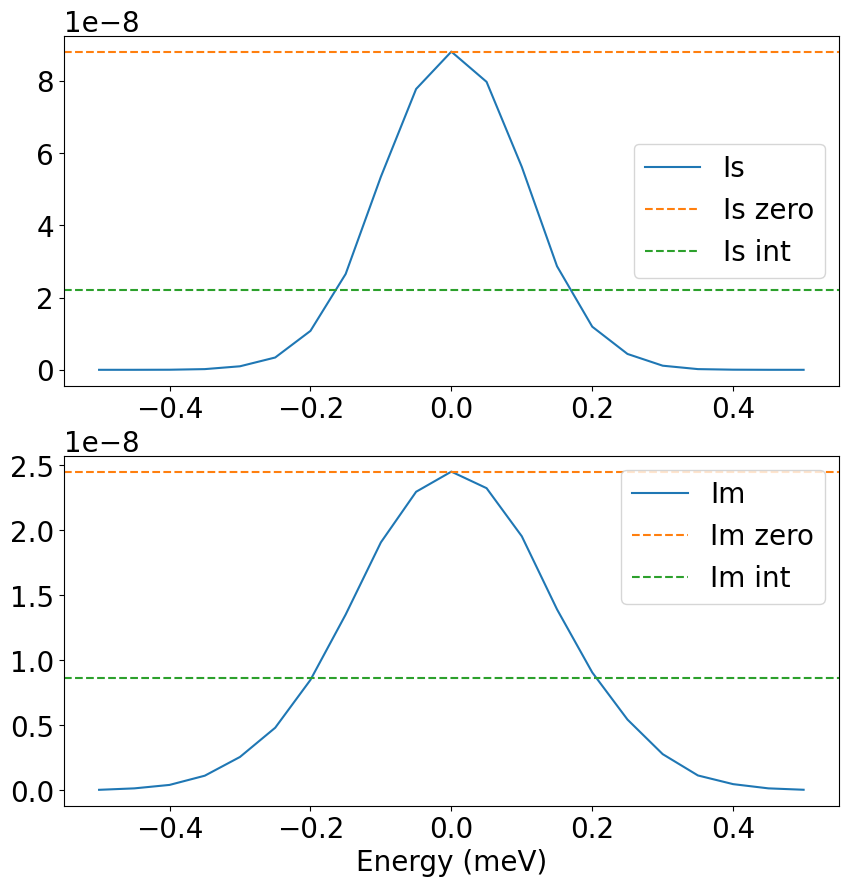

In [9]:
# subplot with two plots with im and is
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(omega_vec, Is, label='Is')

Is_int = np.trapz(Is, omega_vec)
Is_zero = Is[Nomega//2]
ax[0].axhline(y=Is_zero, color='C1', linestyle='--', label='Is zero')
ax[0].axhline(y=Is_int, color='C2', linestyle='--', label='Is int')

ax[0].legend()

ax[1].plot(omega_vec, Im, label='Im')

Im_int = np.trapz(Im, omega_vec)
Im_zero = Im[Nomega//2]
ax[1].axhline(y=Im_zero, color='C1', linestyle='--', label='Im zero')
ax[1].axhline(y=Im_int, color='C2', linestyle='--', label='Im int')

ax[1].set_xlabel('Energy (meV)')
ax[1].legend()

### Correct calculation of $\delta$
The underestimation comes from the wider multiple scattering spectra!

In [10]:
# parameters for the spectrum
domega = 0.03
Nomega = 41
omega_vec = np.linspace(-domega*(Nomega//2), domega*(Nomega//2), Nomega)

data = pd.DataFrame({'d':d_vec, 'ki':ki, 'kf':kf, 'theta':np.rad2deg(theta), 'Is':np.nan, 'Im':np.nan, 'delta':np.nan})

In [11]:
for i in data.index:
    Im = np.zeros(Nomega)
    Is = np.zeros(Nomega)
    for o in range(Nomega):
        geom = ('cuboid', data.d[i], 1000, 1000)
        sim = MS_sim(geom, (mu_s,mu_abs), S_files, data.ki[i], E2k(k2E(data.kf[i])+omega_vec[o]), theta,)
        out = sim.run(N=N, B=B)
        Im[o] = sim.Im
        Is[o] = sim.Is
    data.loc[i,'Is'] = np.trapz(Is, omega_vec)
    data.loc[i,'Im'] = np.trapz(Im, omega_vec)
    data.loc[i,'delta'] = data.Im[i]/data.Is[i]

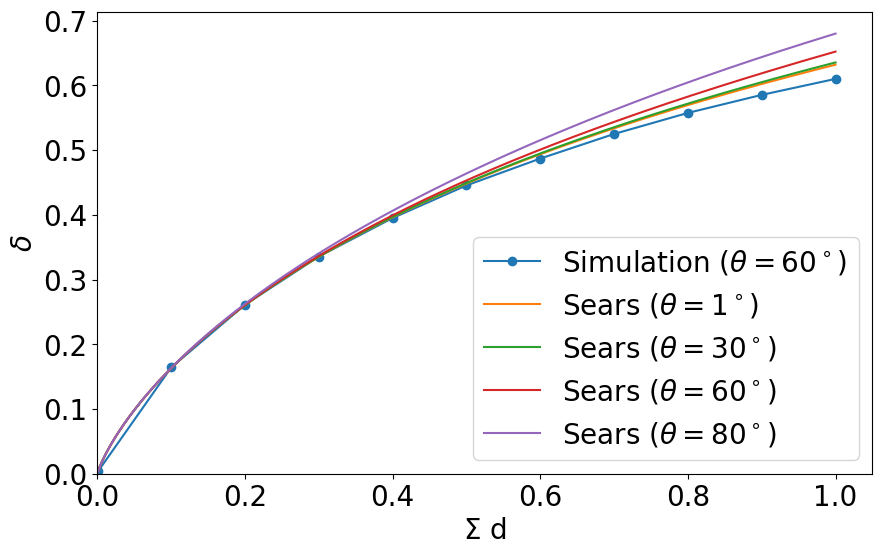

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(data.d, data.delta, 'o-', label = r'Simulation ($\theta = {}^\circ$)'.format(round(np.rad2deg(theta))))
X = np.linspace(data.d.min(), data.d.max(), 1000)
plt.plot(X, delta_slab(X, np.deg2rad(1)), label=r'Sears ($\theta = {}^\circ$)'.format(1))
plt.plot(X, delta_slab(X, np.deg2rad(30)), label=r'Sears ($\theta = {}^\circ$)'.format(30))
plt.plot(X, delta_slab(X, np.deg2rad(60)), label=r'Sears ($\theta = {}^\circ$)'.format(60))
plt.plot(X, delta_slab(X, np.deg2rad(80)), label=r'Sears ($\theta = {}^\circ$)'.format(80))
plt.xlim(0)
plt.ylim(0)

plt.xlabel(r'$\Sigma$ d')
plt.ylabel(r'$\delta$')
plt.legend()

## $\theta$ dependence

In [13]:
d = .1
theta_vec = np.linspace(0, 90, 40)

In [14]:
# parameters for the spectrum
domega = 0.03
Nomega = 21
omega_vec = np.linspace(-domega*(Nomega//2), domega*(Nomega//2), Nomega)

data = pd.DataFrame({'d':d, 'ki':ki, 'kf':kf, 'theta':theta_vec, 'Is':np.nan, 'Im':np.nan, 'delta':np.nan})

In [15]:
for i in data.index:
    Im = np.zeros(Nomega)
    Is = np.zeros(Nomega)
    for o in range(Nomega):
        geom = ('cuboid', data.d[i], 10000, 10000)
        sim = MS_sim(geom, (mu_s,mu_abs), S_files, data.ki[i], E2k(k2E(data.kf[i])+omega_vec[o]), np.deg2rad(data.theta[i]))
        out = sim.run(N=N, B=B)
        Im[o] = sim.Im
        Is[o] = sim.Is
    data.loc[i,'Is'] = np.trapz(Is, omega_vec)
    data.loc[i,'Im'] = np.trapz(Im, omega_vec)
    data.loc[i,'delta'] = data.Im[i]/data.Is[i]

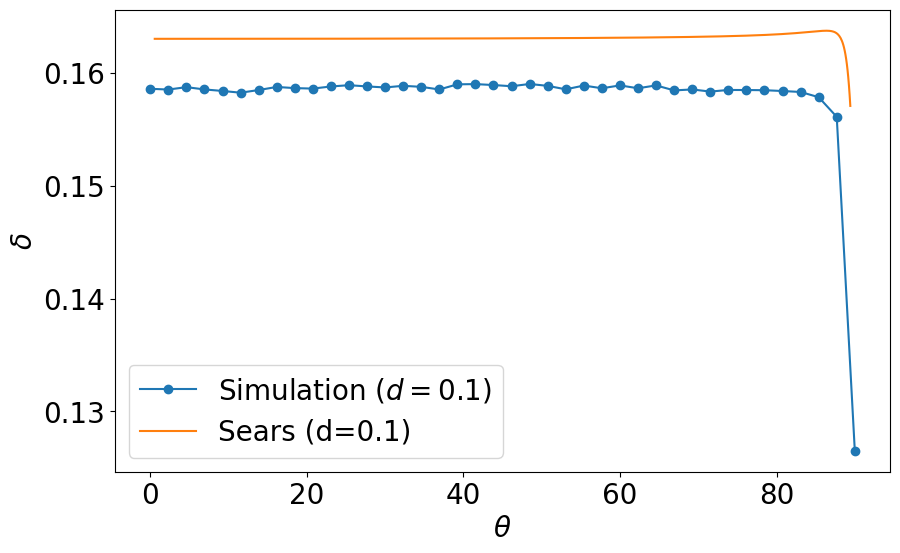

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(data.theta, data.delta, 'o-', label = r'Simulation ($d = {}$)'.format(d))
X = np.linspace(0.01, np.pi/2-0.01, 1000)
plt.plot(np.rad2deg(X), delta_slab(d, X), label=r'Sears (d={})'.format(d))


plt.xlabel(r'$\theta$')
plt.ylabel(r'$\delta$')
plt.legend()

# Cylinder

## Constant r

In [17]:
#####################################################
k = 6
theta=np.deg2rad(60)
d_vec = .01, .02, .03, .04, .05, .06, .07, .08, .09, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 1.1
r = .2
N = 100000
B = 3
#####################################################

ki = kf = k
data = pd.DataFrame({'d':d_vec, 'r':r, 'ki':ki, 'kf':kf, 'theta':np.rad2deg(theta), 'Is':np.nan, 'Im':np.nan, 'delta':np.nan})
print('ki =', ki, 'A-1')
print('kf =', kf, 'A-1')
print('theta =', round(np.rad2deg(theta)), 'deg')


ki = 6 A-1
kf = 6 A-1
theta = 60 deg


In [18]:
# parameters for the spectrum
domega = 0.03
Nomega = 41
omega_vec = np.linspace(-domega*(Nomega//2), domega*(Nomega//2), Nomega)

In [19]:
for i in data.index:
    print('Running r={}, d={}'.format(data.r[i], data.d[i]))
    Im = np.zeros(Nomega)
    Is = np.zeros(Nomega)
    for o in range(Nomega):
        geom = ('cylinder', data.r[i], data.d[i])
        sim = MS_sim(geom, (mu_s,mu_abs), S_files, data.ki[i], E2k(k2E(data.kf[i])+omega_vec[o]), theta,)
        out = sim.run(N=N, B=B)
        Im[o] = sim.Im
        Is[o] = sim.Is
    data.loc[i,'Is'] = np.trapz(Is, omega_vec)
    data.loc[i,'Im'] = np.trapz(Im, omega_vec)
    data.loc[i,'delta'] = data.Im[i]/data.Is[i]

    clear_output(wait=True)

Running r=0.2, d=1.1


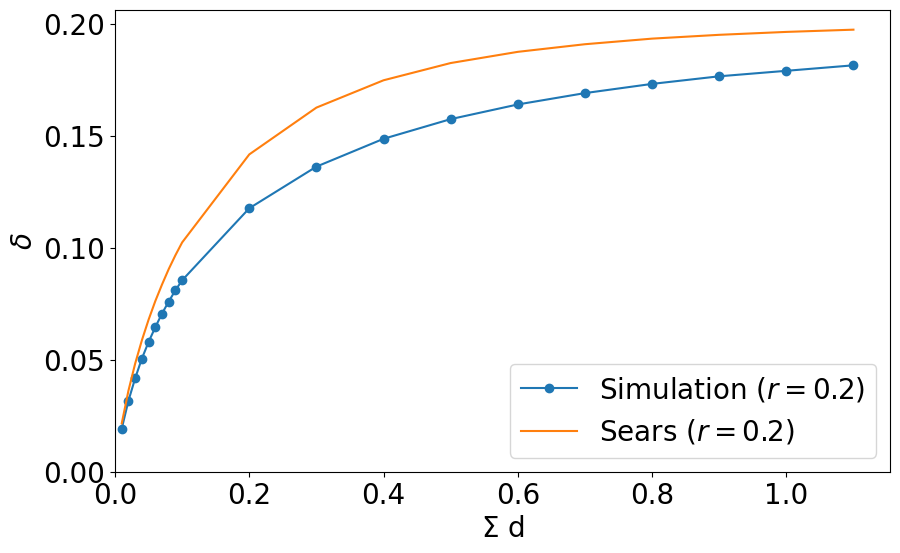

In [20]:
plt.figure(figsize=(10, 6))

plt.plot(data.d, data.delta, 'o-', label = r'Simulation ($r = {}$)'.format(r))
const_r = cylinder[cylinder.r==r]
plt.plot(const_r.d, const_r.delta, label = r'Sears ($r = {}$)'.format(r))

plt.xlim(0)
plt.ylim(0)
plt.xlabel(r'$\Sigma$ d')
plt.ylabel(r'$\delta$')
plt.legend()


## Constant d

In [21]:
#####################################################
k = 6
theta=np.deg2rad(60)
d = .1
r_vec = .01, .02, .03, .04, .05, .06, .07, .08, .09, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 1.1
N = 100000
B = 3
#####################################################

ki = kf = k
data = pd.DataFrame({'d':d, 'r':r_vec, 'ki':ki, 'kf':kf, 'theta':np.rad2deg(theta), 'Is':np.nan, 'Im':np.nan, 'delta':np.nan})
print('ki =', ki, 'A-1')
print('kf =', kf, 'A-1')
print('theta =', round(np.rad2deg(theta)), 'deg')

ki = 6 A-1
kf = 6 A-1
theta = 60 deg


In [22]:
# parameters for the spectrum
domega = 0.03
Nomega = 41
omega_vec = np.linspace(-domega*(Nomega//2), domega*(Nomega//2), Nomega)

In [23]:
for i in data.index:
    print('Running r={}, d={}'.format(data.r[i], data.d[i]))
    Im = np.zeros(Nomega)
    Is = np.zeros(Nomega)
    for o in range(Nomega):
        geom = ('cylinder', data.r[i], data.d[i])
        sim = MS_sim(geom, (mu_s,mu_abs), S_files, data.ki[i], E2k(k2E(data.kf[i])+omega_vec[o]), theta,)
        out = sim.run(N=N, B=B)
        Im[o] = sim.Im
        Is[o] = sim.Is
    data.loc[i,'Is'] = np.trapz(Is, omega_vec)
    data.loc[i,'Im'] = np.trapz(Im, omega_vec)
    data.loc[i,'delta'] = data.Im[i]/data.Is[i]

    clear_output(wait=True)

Running r=1.1, d=0.1


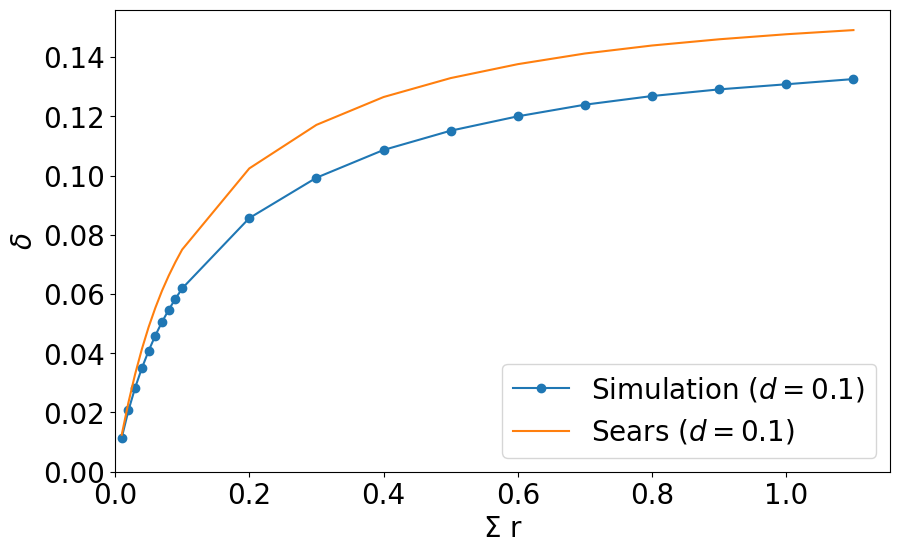

In [24]:
plt.figure(figsize=(10, 6))

plt.plot(data.r, data.delta, 'o-', label = r'Simulation ($d = {}$)'.format(d))
const_d = cylinder[cylinder.d==d]
plt.plot(const_d.r, const_d.delta, label = r'Sears ($d = {}$)'.format(d))

plt.xlim(0)
plt.ylim(0)
plt.xlabel(r'$\Sigma$ r')
plt.ylabel(r'$\delta$')
plt.legend()